In [2]:
import os
import random
import shutil

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image as Image

In [3]:
# Print PyTorch version
print("PyTorch version:", torch.__version__)

# Check if GPU is available and get the GPU device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU device found: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Please ensure your GPU is installed correctly and CUDA/cuDNN are set up properly.")

PyTorch version: 2.5.1+cu124
GPU device found: NVIDIA GeForce GTX 1080 Ti


## Splitting Dataset

In [4]:
def split_dataset(source_folder, destination_folder, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):
    # Cek apakah folder tujuan sudah ada
    if os.path.exists(destination_folder):
        print(f"Folder tujuan '{destination_folder}' sudah ada.")
        return

    # Buat folder train, test, dan validation
    os.makedirs(os.path.join(destination_folder, 'train'))
    os.makedirs(os.path.join(destination_folder, 'test'))
    os.makedirs(os.path.join(destination_folder, 'validation'))

    # List nama folder di dalam source folder
    folders = os.listdir(source_folder)

    for folder in folders:
        # Path ke folder di dalam source folder
        folder_path = os.path.join(source_folder, folder)

        # Ambil daftar file di dalam folder
        files = os.listdir(folder_path)

        # Hitung jumlah file untuk masing-masing subset
        num_files = len(files)
        num_train = int(num_files * train_ratio)
        num_test = int(num_files * test_ratio)
        num_val = int(num_files * val_ratio)

        # Acak urutan file
        random.shuffle(files)

        # Bagi file menjadi subset train, test, dan validation
        train_files = files[:num_train]
        test_files = files[num_train:num_train + num_test]
        val_files = files[num_train + num_test:]

        # Salin file ke dalam subset train
        for file in train_files:
            source_file = os.path.join(folder_path, file)
            dest_file = os.path.join(destination_folder, 'train', folder)
            os.makedirs(dest_file, exist_ok=True)
            dest_file = os.path.join(dest_file, file)
            shutil.copy(source_file, dest_file)

        # Salin file ke dalam subset test
        for file in test_files:
            source_file = os.path.join(folder_path, file)
            dest_file = os.path.join(destination_folder, 'test', folder)
            os.makedirs(dest_file, exist_ok=True)
            dest_file = os.path.join(dest_file, file)
            shutil.copy(source_file, dest_file)

        # Salin file ke dalam subset validation
        for file in val_files:
            source_file = os.path.join(folder_path, file)
            dest_file = os.path.join(destination_folder, 'validation', folder)
            os.makedirs(dest_file, exist_ok=True)
            dest_file = os.path.join(dest_file, file)
            shutil.copy(source_file, dest_file)

    print("Pembagian dataset berhasil.")

# Path sumber dan tujuan
source_folder  = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset'
destination_folder = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_nonAugment'

In [5]:
# Bagi dataset menjadi subset train, test, dan validation
split_dataset(source_folder, destination_folder, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1)

Pembagian dataset berhasil.


## Load Dataset

In [6]:
# Define the base directory where all images are stored
BASE_DIR = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset_nonAugment'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

In [7]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            folder_path = os.path.join(directory, folder)
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        # Resize the image to IMG_SIZE
                        resized_image = cv2.resize(image, IMG_SIZE)

                        images.append(resized_image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [8]:
IMG_SIZE = (224, 224)

train_images, train_labels = load_data(train_dir)
val_images, val_labels = load_data(val_dir)
test_images, test_labels = load_data(test_dir)

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [9]:
def count_images_and_classes(data_dir):
    dataset = datasets.ImageFolder(data_dir)
    num_images = len(dataset)
    num_classes = len(dataset.classes)
    return num_images, num_classes

# Hitung jumlah gambar dan kelas dalam dataset
num_train_images, num_train_classes = count_images_and_classes(train_dir)
num_val_images, num_val_classes = count_images_and_classes(val_dir)
num_test_images, num_test_classes = count_images_and_classes(test_dir)

print(f"Found {num_train_images} training data images having {num_train_classes} classes.")
print(f"Found {num_val_images} validation data images having {num_val_classes} classes.")
print(f"Found {num_test_images} testing data images having {num_test_classes} classes.")

Found 560 training data images having 8 classes.
Found 80 validation data images having 8 classes.
Found 160 testing data images having 8 classes.


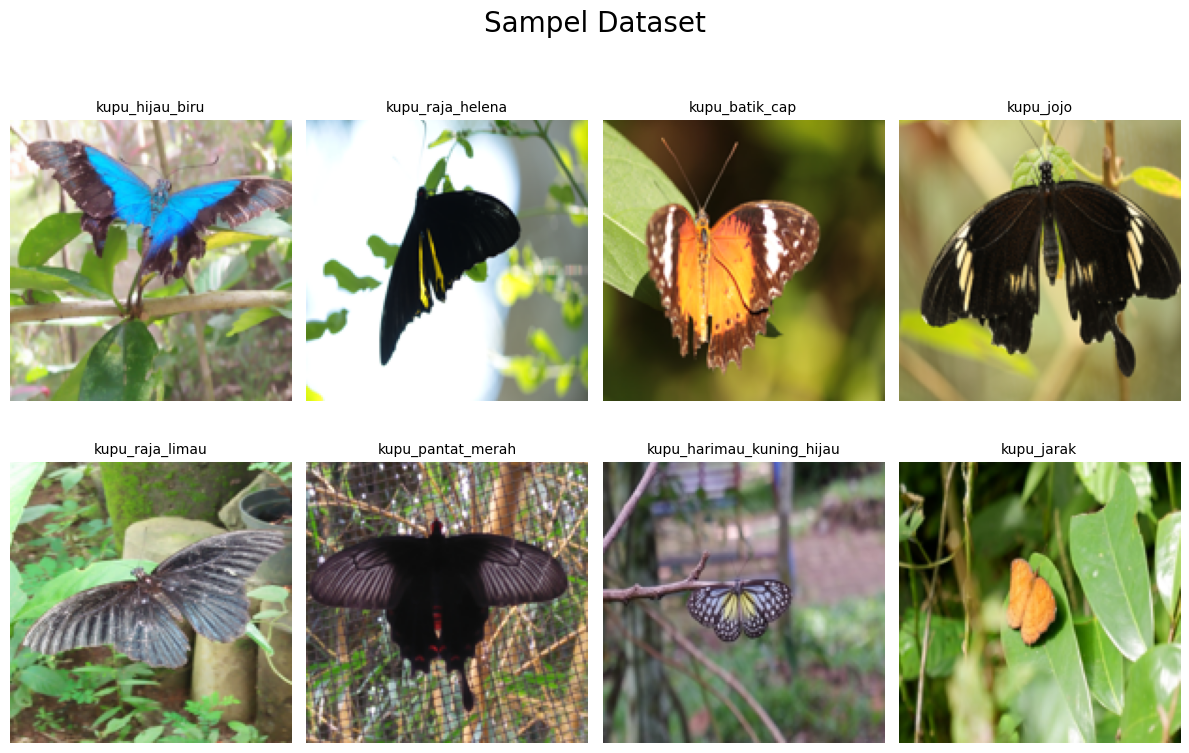

In [10]:
dataset_folder = '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/dataset'

# Mendapatkan daftar subfolder
subfolders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# Membuat grid
num_images = len(subfolders)
images_per_row = 4
num_rows = (num_images + images_per_row - 1) // images_per_row  # Hitung jumlah baris

# Ukuran grid
fig, axes = plt.subplots(nrows=num_rows, ncols=images_per_row, figsize=(12, num_rows * 4))
axes = axes.flatten()

# Ukuran gambar
image_size = (150, 150)  # (lebar, tinggi)
plt.suptitle("Sampel Dataset", fontsize=20, y=1)

# Loop melalui subfolder dan menampilkan gambar pertama dari setiap subfolder
for i, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(dataset_folder, subfolder)
    images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if images:
        # Baca gambar pertama dari subfolder
        img_path = os.path.join(subfolder_path, images[0])
        img = Image.open(img_path)
        
        # Resize gambar agar semua memiliki ukuran yang sama
        img = img.resize(image_size)
        
        # Tampilkan gambar
        axes[i].imshow(img)
        axes[i].set_title(subfolder, fontsize=10)  # Menampilkan nama subfolder sebagai label
        axes[i].axis('off')  # Matikan sumbu

# Menghapus sisa axes jika lebih banyak grid daripada gambar
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Preprocessing

In [11]:
# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [12]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names and number of classes
class_names = train_dataset.classes
nb_classes = len(class_names)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training

In [13]:
wideresnet_model = models.wide_resnet50_2(pretrained=True)
wideresnet_model.fc = nn.Linear(wideresnet_model.fc.in_features, nb_classes)
wideresnet_model = wideresnet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
googlenet_model = models.googlenet(pretrained=True)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, nb_classes)
googlenet_model = googlenet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, nb_classes)
alexnet_model = alexnet_model.to(device)

/home/bioinfo01/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer_wideresnet = optim.Adam(wideresnet_model.parameters(), lr=0.001)
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.001)
optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.001)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

In [18]:
wideresnet_model, history_wideresnet = train_model(wideresnet_model, dataloaders, criterion, optimizer_wideresnet, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.5599 Acc: 0.8214
val Loss: 4.2209 Acc: 0.4125

Epoch 2/20
----------
train Loss: 0.6343 Acc: 0.8446
val Loss: 3.6459 Acc: 0.4750

Epoch 3/20
----------
train Loss: 0.5639 Acc: 0.8339
val Loss: 4.9502 Acc: 0.4375

Epoch 4/20
----------
train Loss: 0.3052 Acc: 0.9179
val Loss: 0.6571 Acc: 0.8375

Epoch 5/20
----------
train Loss: 0.3445 Acc: 0.9089
val Loss: 0.1224 Acc: 0.9750

Epoch 6/20
----------
train Loss: 0.1989 Acc: 0.9464
val Loss: 0.3220 Acc: 0.9250

Epoch 7/20
----------
train Loss: 0.2370 Acc: 0.9286
val Loss: 0.1112 Acc: 0.9875

Epoch 8/20
----------
train Loss: 0.2171 Acc: 0.9321
val Loss: 0.3191 Acc: 0.9375

Epoch 9/20
----------
train Loss: 0.1828 Acc: 0.9464
val Loss: 0.2675 Acc: 0.9500

Epoch 10/20
----------
train Loss: 0.1407 Acc: 0.9518
val Loss: 0.1453 Acc: 0.9500

Epoch 11/20
----------
train Loss: 0.2988 Acc: 0.9143
val Loss: 0.7050 Acc: 0.8125

Epoch 12/20
----------
train Loss: 0.2410 Acc: 0.9196
val Loss: 0.1877 Acc: 0.9500

E

In [19]:
googlenet_model, history_googlenet = train_model(googlenet_model, dataloaders, criterion, optimizer_googlenet, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.5328 Acc: 0.8786
val Loss: 0.2831 Acc: 0.8375

Epoch 2/20
----------
train Loss: 0.1370 Acc: 0.9607
val Loss: 1.5699 Acc: 0.6625

Epoch 3/20
----------
train Loss: 0.1355 Acc: 0.9625
val Loss: 0.2048 Acc: 0.9500

Epoch 4/20
----------
train Loss: 0.1016 Acc: 0.9679
val Loss: 0.1345 Acc: 0.9875

Epoch 5/20
----------
train Loss: 0.1310 Acc: 0.9679
val Loss: 0.1168 Acc: 0.9750

Epoch 6/20
----------
train Loss: 0.1566 Acc: 0.9661
val Loss: 0.0581 Acc: 0.9750

Epoch 7/20
----------
train Loss: 0.1158 Acc: 0.9714
val Loss: 0.0607 Acc: 1.0000

Epoch 8/20
----------
train Loss: 0.0857 Acc: 0.9750
val Loss: 0.0721 Acc: 0.9750

Epoch 9/20
----------
train Loss: 0.0814 Acc: 0.9786
val Loss: 0.0404 Acc: 0.9875

Epoch 10/20
----------
train Loss: 0.1256 Acc: 0.9661
val Loss: 0.0336 Acc: 1.0000

Epoch 11/20
----------
train Loss: 0.1316 Acc: 0.9661
val Loss: 0.0119 Acc: 1.0000

Epoch 12/20
----------
train Loss: 0.0833 Acc: 0.9732
val Loss: 0.0216 Acc: 0.9875

E

In [20]:
alexnet_model, history_alexnet = train_model(alexnet_model, dataloaders, criterion, optimizer_alexnet, num_epochs=20)

Epoch 1/20
----------
train Loss: 1.9196 Acc: 0.3571
val Loss: 2.0086 Acc: 0.2500

Epoch 2/20
----------
train Loss: 1.7750 Acc: 0.3661
val Loss: 1.4761 Acc: 0.4000

Epoch 3/20
----------
train Loss: 1.2374 Acc: 0.5643
val Loss: 0.9765 Acc: 0.7250

Epoch 4/20
----------
train Loss: 1.1005 Acc: 0.6089
val Loss: 1.1877 Acc: 0.5500

Epoch 5/20
----------
train Loss: 1.4258 Acc: 0.4786
val Loss: 1.3438 Acc: 0.5000

Epoch 6/20
----------
train Loss: 1.4040 Acc: 0.4804
val Loss: 1.2459 Acc: 0.5375

Epoch 7/20
----------
train Loss: 1.9157 Acc: 0.3911
val Loss: 2.0754 Acc: 0.1500

Epoch 8/20
----------
train Loss: 1.9843 Acc: 0.2339
val Loss: 1.7295 Acc: 0.3000

Epoch 9/20
----------
train Loss: 1.8586 Acc: 0.2643
val Loss: 1.8332 Acc: 0.2375

Epoch 10/20
----------
train Loss: 1.6824 Acc: 0.3125
val Loss: 1.5326 Acc: 0.4375

Epoch 11/20
----------
train Loss: 1.6843 Acc: 0.3643
val Loss: 1.4555 Acc: 0.4500

Epoch 12/20
----------
train Loss: 1.4661 Acc: 0.3804
val Loss: 3.4788 Acc: 0.4750

E

In [30]:
# Save the models
torch.save(wideresnet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/wideresnet_model.pth')
torch.save(googlenet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/googlenet_model.pth')
torch.save(alexnet_model.state_dict(), '/home/bioinfo01/Desktop/BIMB PAK RICO/2117051075_Adli Fiqrullah/alexnet_model.pth')

## Testing

In [36]:
# Function to load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['test'](image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to make predictions
def predict_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.item()

# Function to display image and prediction
def display_predictions(images_paths, predictions, class_names, model_names, accuracies, species_accuracies):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        image = Image.open(images_paths[i])
        ax.imshow(image)
        pred_text = (f"{class_names[i]}\n"
                     f"{model_names[0]}: {class_names[predictions[i][0]]}\n"
                     f"{model_names[1]}: {class_names[predictions[i][1]]}\n"
                     f"{model_names[2]}: {class_names[predictions[i][2]]}\n"
                     f"Acc {model_names[0]}: {species_accuracies[0][i]:.2f}, {model_names[1]}: {species_accuracies[1][i]:.2f}, {model_names[2]}: {species_accuracies[2][i]:.2f}")
        ax.text(260, 20, pred_text, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8), linespacing=1)
        ax.axis('off')
    fig.suptitle(f"Overall Accuracies: WRN: {accuracies[0]:.2f}, GN: {accuracies[1]:.2f}, AN: {accuracies[2]:.2f}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [37]:
# Define the paths to sample images from each class
sample_images_paths = []
for class_name in class_names:
    class_folder = os.path.join(test_dir, class_name)
    sample_image = os.path.join(class_folder, os.listdir(class_folder)[0])
    sample_images_paths.append(sample_image)

# Load and preprocess the images
images_tensors = [load_image(image_path) for image_path in sample_images_paths]

# Make predictions using the three models
wideresnet_predictions = [predict_image(wideresnet_model, img_tensor) for img_tensor in images_tensors]
googlenet_predictions = [predict_image(googlenet_model, img_tensor) for img_tensor in images_tensors]
alexnet_predictions = [predict_image(alexnet_model, img_tensor) for img_tensor in images_tensors]

# Combine predictions for display
predictions = list(zip(wideresnet_predictions, googlenet_predictions, alexnet_predictions))

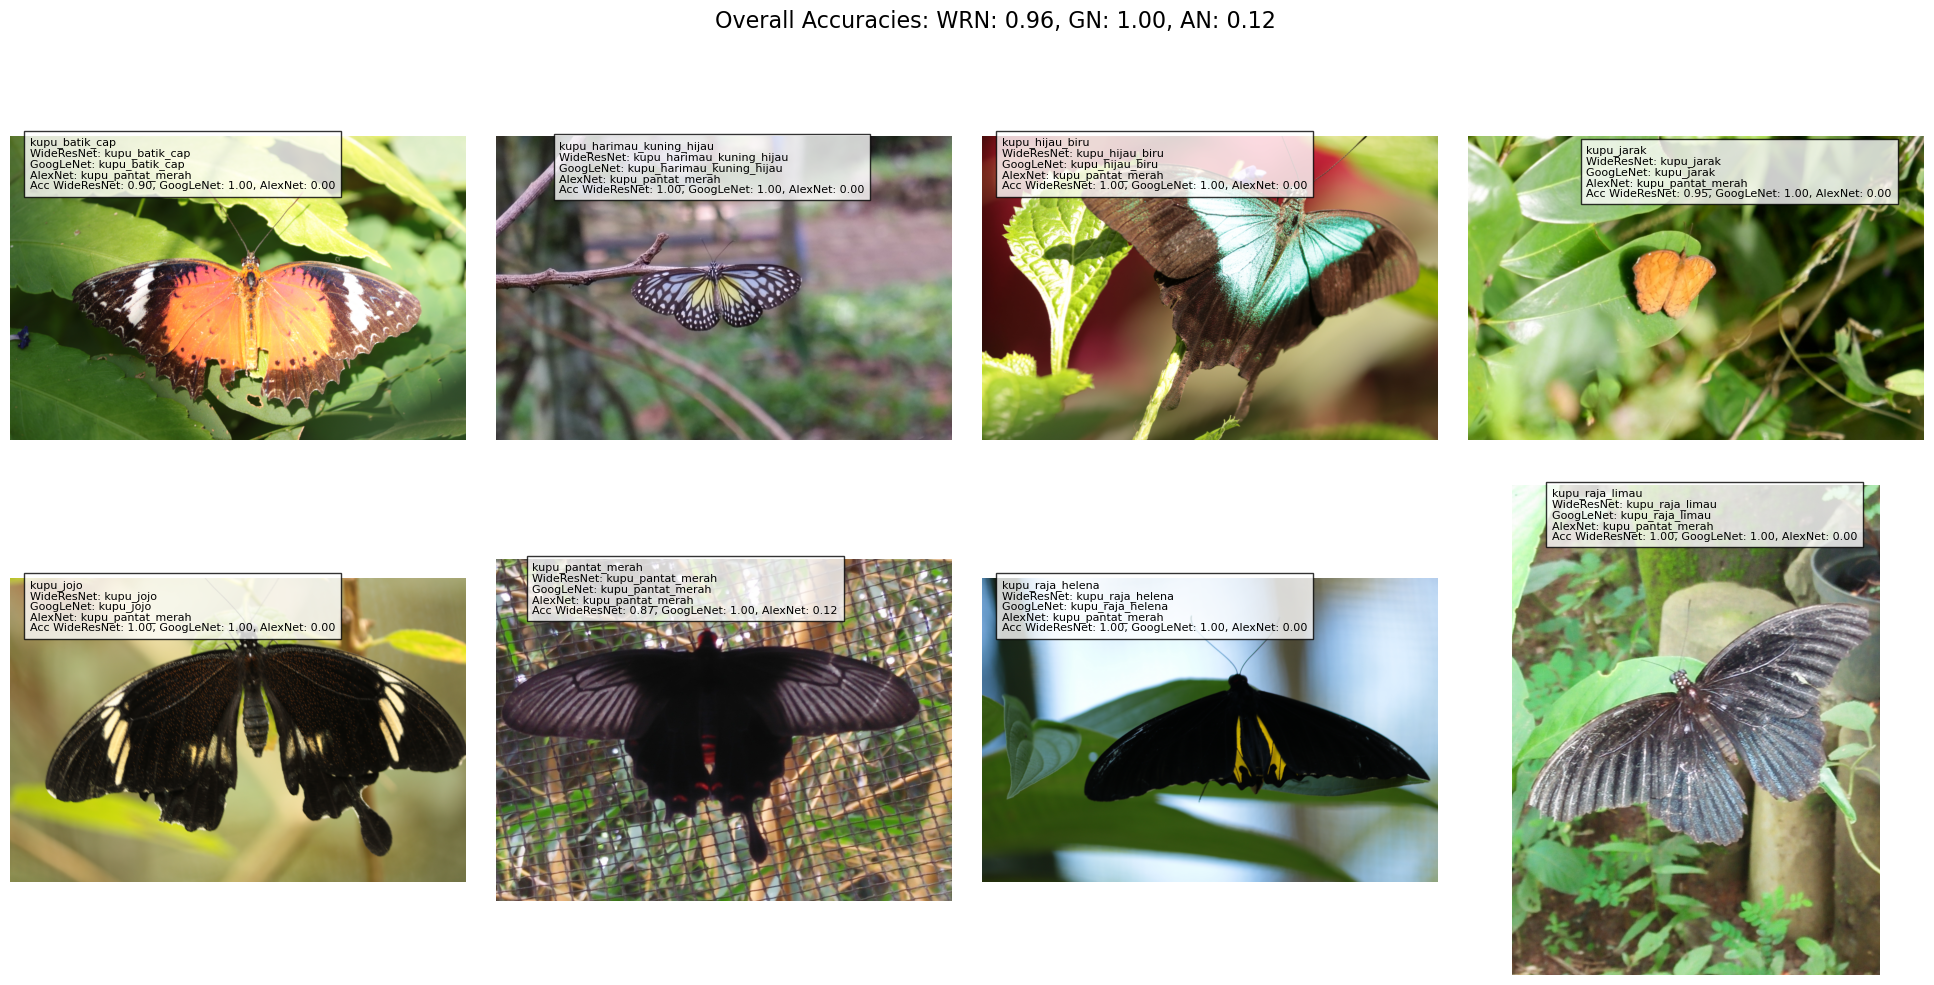

In [38]:
# Calculate accuracies for each model on the entire test set
def calculate_accuracy(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    return accuracy, report

# Create DataLoader for test set
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Calculate accuracies
wideresnet_accuracy, wideresnet_report = calculate_accuracy(wideresnet_model, test_loader)
googlenet_accuracy, googlenet_report = calculate_accuracy(googlenet_model, test_loader)
alexnet_accuracy, alexnet_report = calculate_accuracy(alexnet_model, test_loader)

accuracies = [wideresnet_accuracy, googlenet_accuracy, alexnet_accuracy]

# Extract accuracies per species
wideresnet_species_accuracies = [wideresnet_report[class_name]['precision'] for class_name in class_names]
googlenet_species_accuracies = [googlenet_report[class_name]['precision'] for class_name in class_names]
alexnet_species_accuracies = [alexnet_report[class_name]['precision'] for class_name in class_names]

species_accuracies = [wideresnet_species_accuracies, googlenet_species_accuracies, alexnet_species_accuracies]

# Model names
model_names = ['WideResNet', 'GoogLeNet', 'AlexNet']

# Display the images and predictions
display_predictions(sample_images_paths, predictions, class_names, model_names, accuracies, species_accuracies)

## Evaluation

In [39]:
# Function to plot the accuracy and loss curves
def plot_accuracy_loss(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

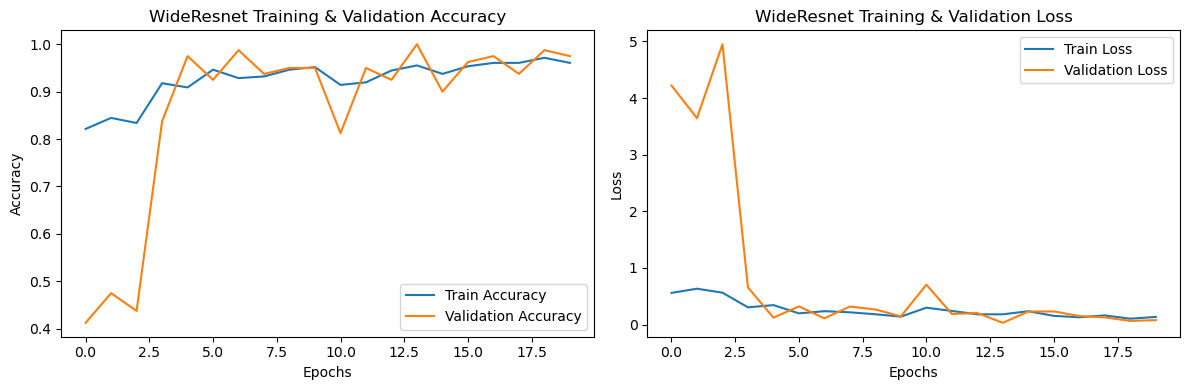

In [40]:
plot_accuracy_loss(history_wideresnet, 'WideResnet')

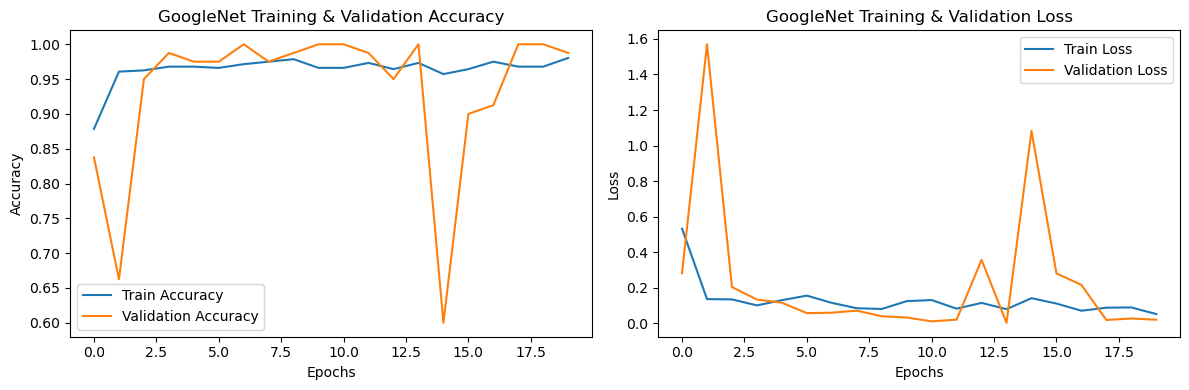

In [41]:
plot_accuracy_loss(history_googlenet, 'GoogleNet')

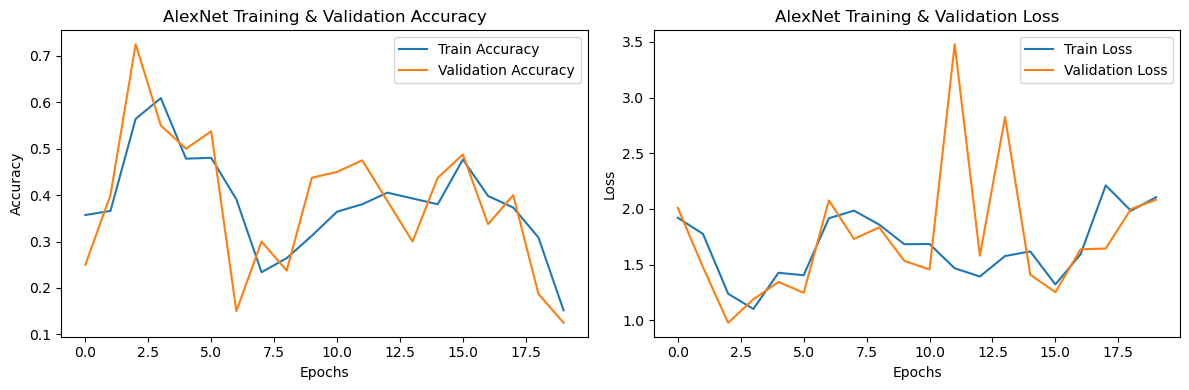

In [42]:
plot_accuracy_loss(history_alexnet, 'AlexNet')

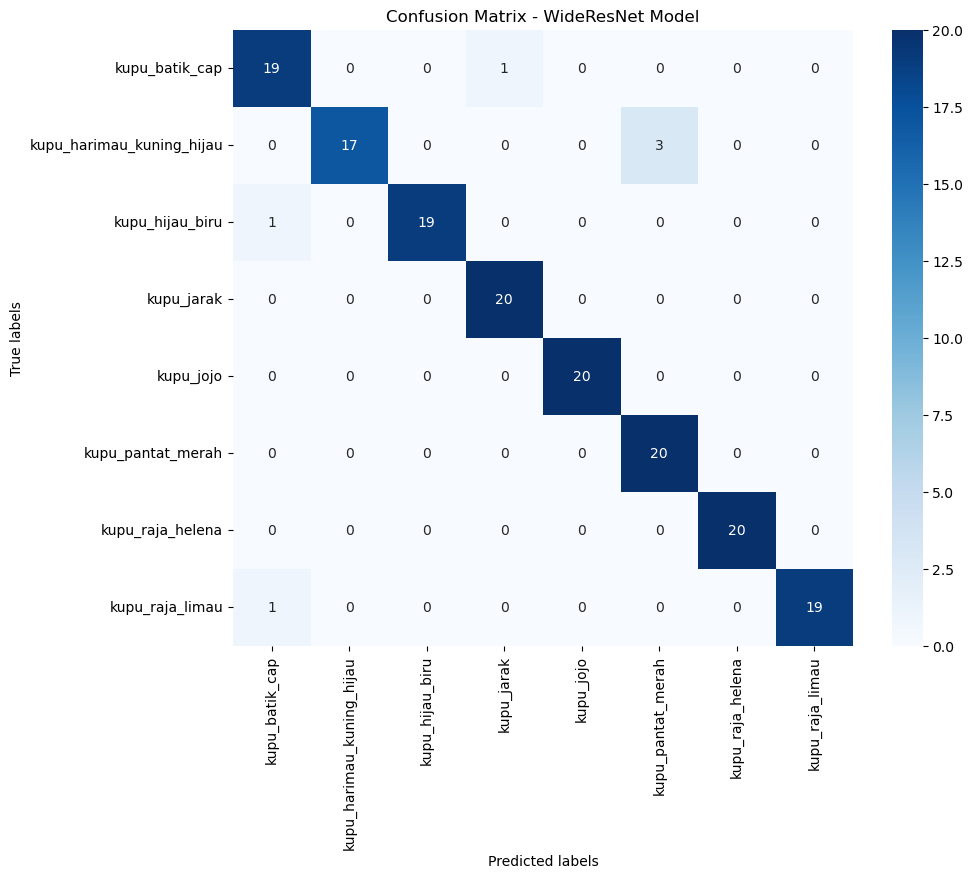

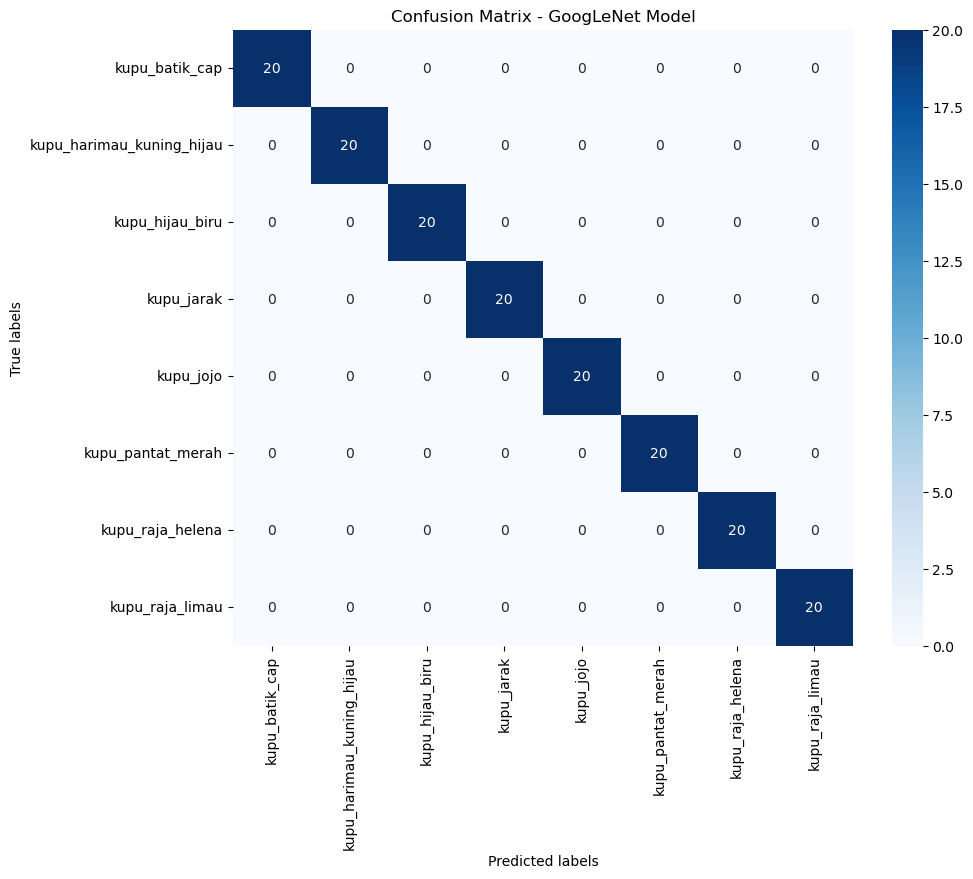

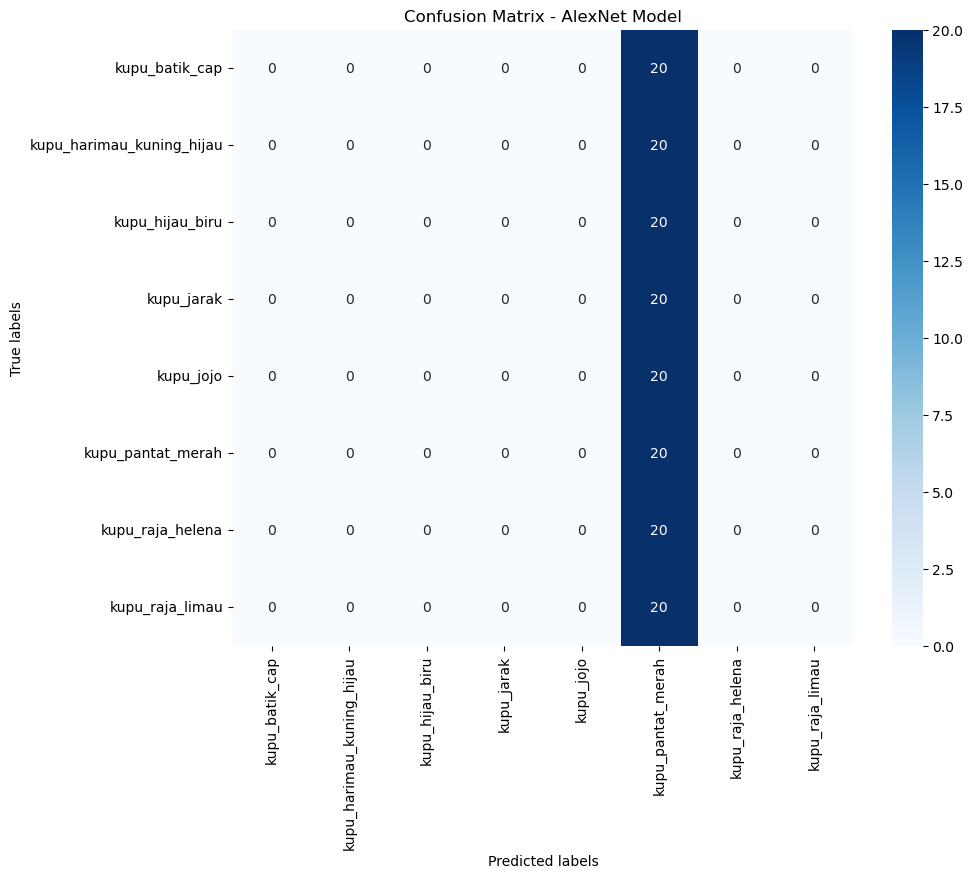

In [43]:
def evaluate_model(model, dataloaders):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

# Evaluate models
dataloaders['test'] = test_loader

wideresnet_labels, wideresnet_preds = evaluate_model(wideresnet_model, dataloaders)
googlenet_labels, googlenet_preds = evaluate_model(googlenet_model, dataloaders)
alexnet_labels, alexnet_preds = evaluate_model(alexnet_model, dataloaders)

def plot_confusion_matrix(true_labels, predicted_labels, class_names, title):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(wideresnet_labels, wideresnet_preds, class_names, 'Confusion Matrix - WideResNet Model')
plot_confusion_matrix(googlenet_labels, googlenet_preds, class_names, 'Confusion Matrix - GoogLeNet Model')
plot_confusion_matrix(alexnet_labels, alexnet_preds, class_names, 'Confusion Matrix - AlexNet Model')

In [44]:
def calculate_metrics(conf_matrix):
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
        precision[np.isnan(precision)] = 0

        recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
        recall[np.isnan(recall)] = 0

        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_score[np.isnan(f1_score)] = 0

    return precision, recall, f1_score

# Calculate metrics
wideresnet_conf_matrix = confusion_matrix(wideresnet_labels, wideresnet_preds)
googlenet_conf_matrix = confusion_matrix(googlenet_labels, googlenet_preds)
alexnet_conf_matrix = confusion_matrix(alexnet_labels, alexnet_preds)

wideresnet_precision, wideresnet_recall, wideresnet_f1_score = calculate_metrics(wideresnet_conf_matrix)
googlenet_precision, googlenet_recall, googlenet_f1_score = calculate_metrics(googlenet_conf_matrix)
alexnet_precision, alexnet_recall, alexnet_f1_score = calculate_metrics(alexnet_conf_matrix)

metrics_df = pd.DataFrame({
    'class_name': class_names,
    'WideResNet_precision': wideresnet_precision,
    'WideResNet_recall': wideresnet_recall,
    'WideResNet_F1_score': wideresnet_f1_score,
    'GoogLeNet_precision': googlenet_precision,
    'GoogLeNet_recall': googlenet_recall,
    'GoogLeNet_F1_score': googlenet_f1_score,
    'AlexNet_precision': alexnet_precision,
    'AlexNet_recall': alexnet_recall,
    'AlexNet_F1_score': alexnet_f1_score
})
metrics_df

class_name  WideResNet_precision  WideResNet_recall  \
0             kupu_batik_cap              0.904762               0.95   
1  kupu_harimau_kuning_hijau              1.000000               0.85   
2            kupu_hijau_biru              1.000000               0.95   
3                 kupu_jarak              0.952381               1.00   
4                  kupu_jojo              1.000000               1.00   
5          kupu_pantat_merah              0.869565               1.00   
6           kupu_raja_helena              1.000000               1.00   
7            kupu_raja_limau              1.000000               0.95   

   WideResNet_F1_score  GoogLeNet_precision  GoogLeNet_recall  \
0             0.926829                  1.0               1.0   
1             0.918919                  1.0               1.0   
2             0.974359                  1.0               1.0   
3             0.975610                  1.0               1.0   
4             1.000000                  1.0               1.0   
5             0.930233                  1.0               1.0   
6             1.000000                  1.0               1.0   
7             0.974359                  1.0               1.0   

   GoogLeNet_F1_score  AlexNet_precision  AlexNet_recall  AlexNet_F1_score  
0                 1.0              0.000             0.0          0.000000  
1                 1.0              0.000             0.0          0.000000  
2                 1.0              0.000             0.0          0.000000  
3                 1.0              0.000             0.0          0.000000  
4                 1.0              0.000             0.0          0.000000  
5                 1.0              0.125             1.0          0.222222  
6                 1.0              0.000             0.0          0.000000  
7                 1.0              0.000             0.0          0.000000